In [ ]:
!pwd

In [ ]:
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from model.model import PretrainModelTimmArc
from data_loader.datasets import MaskDataset, MaskSubDataset, MaskSubmitDataset
from data_loader.data_loaders import MaskDataLoader
from torchvision import transforms
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np

# Create the datset and load the trained model

In [4]:

data_loader_args = {
    "data_dir": "../input/data",
    "batch_size": 32,
    "shuffle": False,
    "validation_split": 0.1,
    "num_workers": 2,
    "submit": True,
    "sampler": "over"
}
train_data_loader, valid_data_loader, submit_data_loader = MaskDataLoader(**data_loader_args).split_validation()

/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Current transforms : None
num_workers:  2
Apply Oversampling, Turn off the shuffle


In [5]:
train_dataset = train_data_loader.dataset
valid_dataset = valid_data_loader.dataset
submit_dataset = submit_data_loader.dataset

In [6]:
model = PretrainModelTimmArc()
checkpoint = torch.load("/opt/ml/image-classification-level1-04/saved/models/EfficientNet_b3_Cutout_Elastic_CLAHE_Transform_LabelSmoothing_InputSize384/0901_030840/model_best.pth")
model.load_state_dict(checkpoint['state_dict'])

RuntimeError: CUDA error: out of memory

In [42]:
# model = torch.nn.DataParallel(model)
print("done model loading")

<All keys matched successfully>

---

# Evaluate Validation set based on Train set

In [4]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [36]:
device = torch.device("cuda")
model.to(device)

In [37]:
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(normalize_embeddings=True,
                    use_trunk_output=False,
                    batch_size=64,
                    dataloader_num_workers=4,
                    pca=None,
                    data_device=device,
                    dtype=None,
                    data_and_label_getter=None,
                    label_hierarchy_level=0,
                    end_of_testing_hook=None,
                    dataset_labels=None,
                    set_min_label_to_zero=False,
                    accuracy_calculator=None,
                    visualizer=None,
                    visualizer_hook=None,)
    return tester.get_all_embeddings(dataset, model)

In [38]:
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    print(train_labels)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


In [39]:
accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)

In [44]:
test(train_dataset, valid_dataset, model, accuracy_calculator)

  0%|          | 0/30 [00:00<?, ?it/s]

tensor([[ 1],
        [10],
        [ 4],
        ...,
        [ 4],
        [ 4],
        [ 0]], device='cuda:0')


100%|██████████| 30/30 [00:06<00:00,  4.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9904762040823698


---

# Inference on the Submit Dataset

In [45]:
submit_dataset = submit_data_loader.dataset

## Create helper functions

In [49]:
def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [51]:
labels_to_indices = c_f.get_labels_to_indices(train_dataset.get_labels().values)

In [52]:
labels_to_indices

defaultdict(list,
            {1: array([    0,    15,    24, ..., 16979, 16994, 16999]),
             10: array([    1,     8,    30,    40,    92,   138,   146,   190,   197,
                      206,   211,   281,   286,   288,   291,   298,   330,   333,
                      334,   374,   450,   459,   473,   479,   497,   539,   551,
                      559,   614,   657,   704,   717,   732,   756,   759,   789,
                      796,   807,   849,   850,   854,   864,   867,   908,   929,
                      961,   977,  1036,  1074,  1076,  1107,  1115,  1136,  1146,
                     1158,  1228,  1231,  1274,  1294,  1309,  1322,  1336,  1491,
                     1499,  1506,  1562,  1572,  1581,  1600,  1609,  1616,  1635,
                     1683,  1722,  1777,  1783,  1883,  1943,  1970,  1994,  2005,
                     2020,  2049,  2064,  2066,  2100,  2114,  2120,  2128,  2161,
                     2174,  2205,  2213,  2221,  2227,  2299,  2316,  2349, 

In [53]:
dataset = train_data_loader.dataset

In [ ]:
# classA, classB = labels_to_indices[4], labels_to_indices[5]

In [61]:
model = PretrainModelTimmArc()
checkpoint = torch.load("/opt/ml/image-classification-level1-04/saved/models/EfficientNet_b3_Cutout_Elastic_CLAHE_Transform_LabelSmoothing_InputSize384/0901_030840/model_best.pth")
model.load_state_dict(checkpoint['state_dict'])
model = torch.nn.DataParallel(model)
model.to(torch.device("cuda"))

DataParallel(
  (module): PretrainModelTimmArc(
    (model): EfficientNet(
      (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False

In [62]:
# initialize with a model
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.7)
inference_model = InferenceModel(model, match_finder=match_finder)

In [63]:
# create faiss index
# pass in a dataset to serve as the search space for k-nn
# It take's long time (3m on V100)
inference_model.train_indexer(dataset)

query image


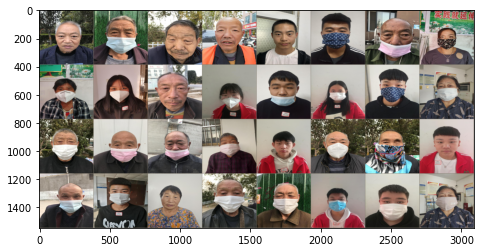

nearest images
nearest classes


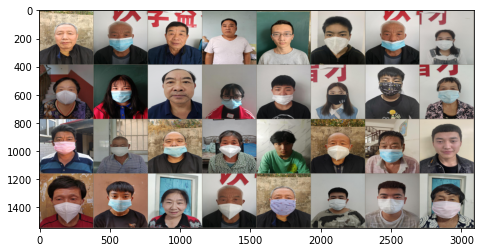

[13, 2, 13, 13, 12, 0, 8, 4, 4, 3, 13, 3, 6, 3, 0, 4, 1, 1, 7, 4, 12, 1, 1, 12, 1, 0, 16, 2, 1, 0, 0, 4]


In [141]:
for img in submit_data_loader:
    print("query image")
    imshow(torchvision.utils.make_grid(img))
    samples, distances = inference_model.get_nearest_neighbors(img, k=1)
    nearest_imgs = [dataset[i][0] for i in samples.flatten()]
    print("nearest images")
    nearest_imgs = [dataset[i][0] for i in samples.flatten()]
    nearest_classes = [dataset[i][1].item() for i in samples.flatten()]
    print("nearest classes")
    imshow(torchvision.utils.make_grid(nearest_imgs))
    print(nearest_classes)
    break

In [ ]:
[13, 2, 13, 13, 12, 0, 8, 4, 4, 3, 13, 3, 6, 3, 0, 4, 1, 1, 7, 4, 12, 1, 1, 12, 1, 0, 16, 2, 1, 0, 0, 4]

In [134]:
predicts

array([[13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
       [ 2,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
       [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [12, 12, 12, 

In [ ]:
# get the 10 nearest neighbors of a query
for query in sumbit_data_loader:
    indices, distances = im.get_nearest_neighbors(query, k=10)

## Get nearest neighbors of a query

In [ ]:
# get 10 nearest neighbors for a car image
for img_type in [classA, classB]:
    img = dataset[img_type[0]][0].unsqueeze(0)
    print("query image")
    imshow(torchvision.utils.make_grid(img))
    indices, distances = inference_model.get_nearest_neighbors(img, k=10)
    nearest_imgs = [dataset[i][0] for i in indices[0]]
    print("nearest images")
    imshow(torchvision.utils.make_grid(nearest_imgs))

## Compare two images of the same class

In [ ]:
# compare two images of the same class
(x, _), (y, _) = dataset[classA[0]], dataset[classA[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare two images of different classes

In [ ]:
# compare two images of a different class
(x, _), (y, _) = dataset[classA[0]], dataset[classB[0]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare multiple pairs of images

In [ ]:
# compare multiple pairs of images
x = torch.zeros(20, 3, 384, 384)
y = torch.zeros(20, 3, 384, 384)
for i in range(0, 20, 2):
    x[i] = dataset[classA[i]][0]
    x[i+1] = dataset[classB[i]][0]
    y[i] = dataset[classA[i+20]][0]
    y[i+1] = dataset[classB[i+20]][0]
imshow(torchvision.utils.make_grid(torch.cat((x,y), dim=0), nrow=20), figsize=(30, 3))
decision = inference_model.is_match(x, y)
for d in decision:
    print_decision(d)
print("accuracy = {}".format(np.sum(decision)/len(x)))

## Compare all pairs within a batch

In [ ]:
# compare all pairs within a batch
match_matrix = inference_model.get_matches(x)
assert match_matrix[0,0] # the 0th image should match with itself
imshow(torchvision.utils.make_grid(torch.stack((x[3],x[4]), dim=0)))
print_decision(match_matrix[3,4]) # does the 3rd image match the 4th image?

In [ ]:
# compare all pairs between queries and references
match_matrix = inference_model.get_matches(x, y)
imshow(torchvision.utils.make_grid(torch.stack((x[6],y[6]), dim=0)))
print_decision(match_matrix[6, 6]) # does the 6th query match the 6th reference?

In [ ]:
# make a new model with high threshold
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.95)
inference_model = InferenceModel(model, match_finder=match_finder)

# get all matches in tuple form
match_tuples = inference_model.get_matches(x, y, return_tuples=True)
print("MATCHING IMAGE PAIRS")
for i,j in match_tuples:
    print(i,j)
    imshow(torchvision.utils.make_grid(torch.stack((x[i],y[j]), dim=0)))